# MAD-EEG Dataset preprocessed - How to use it with Python

In [2]:
import numpy as np
import h5py
import yaml
import os

import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

## Folder structure 

The dataset folder contains:

- Two subfolders: one containing the raw data and the other containing the preprocessed data;
- Two notebooks: one explaining the raw data and the other explaining the preprocessed one.
- One .xlsx file containing the behavioural data collected during the experiments;

In [8]:
os.listdir()

['.ipynb_checkpoints',
 'Tutorial-MAD-EEG_preprocessed.ipynb',
 'raw',
 'Tutorial-MAD-EEG_raw.ipynb',
 'behavioural_data.xlsx',
 'preprocessed']

## Preprocessed Data

Inside the subfolder 'preprocessed', the data is already organized for the attention decoding task. It means that each file will contain the music stimulus aligned with the corresponding EEG response.

In [9]:
path = './preprocessed'
os.listdir(path)

['madeeg_preprocessed.hdf5', 'madeeg_preprocessed.yaml']

The .hdf5 file contains the data while the .yaml file contains its metadata.

In [12]:
data = h5py.File(os.path.join(path, 'madeeg_preprocessed.hdf5'), 'r')
data.keys()

<KeysViewHDF5 ['0001', '0002', '0003', '0004', '0005', '0007', '0008', '0009']>

In [13]:
stream = open(os.path.join(path, 'madeeg_preprocessed.yaml'), 'r')
metadata = yaml.load(stream, Loader=yaml.FullLoader)
metadata.keys()

dict_keys(['0001', '0002', '0003', '0004', '0005', '0007', '0008', '0009'])

The two data structures are identical and are organized hierarchically:

- groups correspond to subjects
- subgroups correspond to the stimuli listened to by the given subject

Let us take as an example subject 1

In [14]:
sbj = '0001'
for key in data[sbj].keys():
    print(key)

classique_morceau1_duo_CoFl_theme1_stereo_Co
classique_morceau1_duo_CoFl_theme1_stereo_Fl
classique_morceau1_duo_CoOb_theme1_stereo_Co
classique_morceau1_duo_CoOb_theme2_stereo_Ob
classique_morceau1_duo_FlOb_theme1_stereo_Fl
classique_morceau1_duo_FlOb_theme2_stereo_Ob
classique_morceau1_trio_CoFlOb_theme1_stereo_Co
classique_morceau1_trio_CoFlOb_theme1_stereo_Ob
classique_morceau1_trio_CoFlOb_theme2_stereo_Fl
classique_morceau2_duo_BoFh_theme1_stereo_Fh
classique_morceau2_duo_BoFh_theme2_stereo_Bo
classique_morceau2_duo_BoFl_theme1_stereo_Fl
classique_morceau2_duo_BoFl_theme2_stereo_Bo
classique_morceau2_duo_FhFl_theme2_stereo_Fh
classique_morceau2_duo_FhFl_theme2_stereo_Fl
classique_morceau2_trio_BoFhFl_theme1_stereo_Bo
classique_morceau2_trio_BoFhFl_theme1_stereo_Fh
classique_morceau2_trio_BoFhFl_theme2_stereo_Fl
pop_falldead_duo_BsDr_theme1_stereo_Bs
pop_falldead_duo_BsDr_theme1_stereo_Dr
pop_falldead_duo_GtVx_theme1_stereo_Gt
pop_falldead_duo_GtVx_theme1_stereo_Vx
pop_falldead_tri

The name of each subgroup contains many informations about the corresponding stimulus:
- the music genre (pop/classique)
- the song from which the stimulus is extracted (morceau1/morceau2 for classic music and falldad/mitape for pop music)
- the number of instruments in the mixture (duo/trio)
- the instruments in the mixture
- the theme that is played in that excerpt (for the same song there are two different themes)
- spatial rendering during the listenig (mono/stereo)
- the instrument attended by the listener

In [15]:
stimulus_name = key
print('stimulus name: ', stimulus_name)

stimulus_split = stimulus_name.split('_')
print('genre: ', stimulus_split[0])
print('song: ', stimulus_split[1])
print('ensemble: ', stimulus_split[2])
print('instruments: ', stimulus_split[3])
print('theme: ', stimulus_split[4])
print('spatial: ', stimulus_split[5])
print('target: ', stimulus_split[6])

stimulus name:  pop_mixtape_trio_GtDrVx_theme2_stereo_Dr
genre:  pop
song:  mixtape
ensemble:  trio
instruments:  GtDrVx
theme:  theme2
spatial:  stereo
target:  Dr


The same information can be found already parsed in the metadata

In [17]:
print('genre: ', metadata[sbj][stimulus_name]['genre'])
print('song: ', metadata[sbj][stimulus_name]['song'])
print('ensemble: ', metadata[sbj][stimulus_name]['ensemble'])
print('instruments: ', metadata[sbj][stimulus_name]['instruments'])
print('theme: ', metadata[sbj][stimulus_name]['theme'])
print('spatial: ', metadata[sbj][stimulus_name]['spatial'])
print('target: ', metadata[sbj][stimulus_name]['target'])

genre:  pop
song:  mixtape
ensemble:  trio
instruments:  ['Gt', 'Dr', 'Vx']
theme:  theme2
spatial:  stereo
target:  Dr


Each subgroup is associated to one stimulus and one subject and contains:
- the audio stimulus ('stimulus')
- the isolated sources ('soli')
- the EEG response ('response')

In [12]:
data[sbj][stimulus_name].keys()

<KeysViewHDF5 ['response', 'soli', 'stimulus']>

The field 'stimulus' contains the numpy.ndarray of the stimulus that was listened by the subject. The shape of the array is 2xN, where 2 is the number of channels and N the number of samples. The sampling frequency of the audio is 44100 Hz and can be found in the metadata.

<class 'h5py._hl.dataset.Dataset'>
(2, 1058916)


Text(0.5, 1.0, 'Spectrogram')

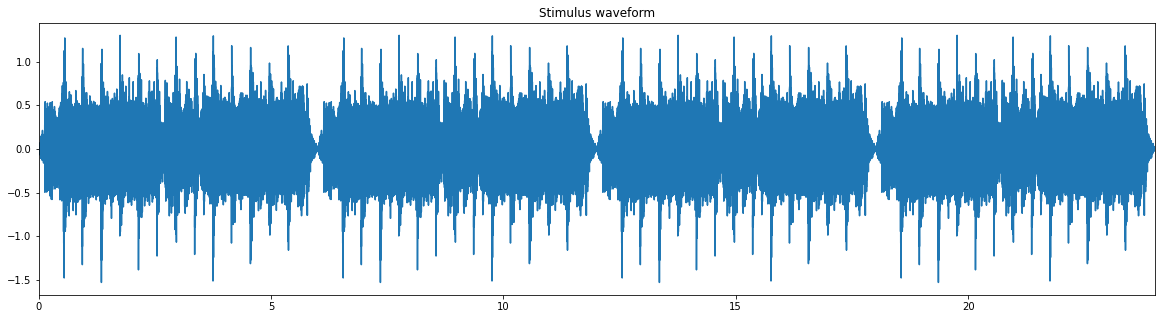

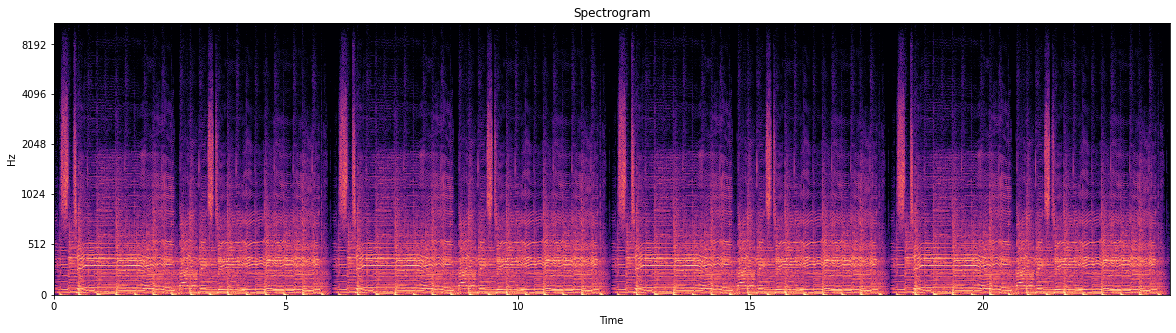

In [20]:
stimulus = data[sbj][stimulus_name]['stimulus']
sfreq = metadata[sbj][stimulus_name]['wav_info']['sfreq']

print(type(stimulus))
print(stimulus.shape)

ch1 = stimulus[0, :]
ch2 = stimulus[1, :]
mix = ch1 + ch2

T = len(mix)/sfreq

plt.figure(figsize=(20,5))
plt.plot(np.linspace(0, T, len(mix)), mix)
plt.xlim((0,T))
plt.title('Stimulus waveform')

plt.figure(figsize=(20,5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(mix)), ref=np.max), x_axis='time', y_axis='mel', sr=sfreq)
plt.title('Spectrogram')

The isolated sources used to build the mixture are saved in the field named 'soli', which contains a numpy.ndarray of shape 3 x N, where N the number of samples. If the mixtures is a duo, then the third row of the matrix will be empty.

In [21]:
soli = data[sbj][stimulus_name]['soli']
print(type(soli))
print(soli.shape)

<class 'h5py._hl.dataset.Dataset'>
(3, 1058916)


The sources are ordered as in th instrument list that can be found in the metadata.

In [22]:
instruments_list = metadata[sbj][stimulus_name]['instruments']
print(instruments_list)

['Gt', 'Dr', 'Vx']


Therefore, they need to be uploaded accordingly. Also the 'gains' and the 'panning' fields are associate to the instruments the same way.
- 'gains': is list of the gains used to mix the isolated sources into the mixture;
- 'panning': is list of the pannnings used to render the stimulus spatially;

This means that to recreate the linear mixture starting from th isolated sources we need to use both the gain and the panning information as follows:

$$ch1 = \sum_i g_i * p_i * s_i$$

$$ch2 = \sum_i g_i * (1 - p_i) * s_i$$

In the mono case, the panning will be 0.5 for all instruments. This means that the two chennels are identical. 

Instrument: Gt
- gain: 0.7
- panning: 0.8
Instrument: Dr
- gain: 1.4
- panning: 0.5
Instrument: Vx
- gain: 0.9
- panning: 0.2


<Figure size 1440x720 with 0 Axes>

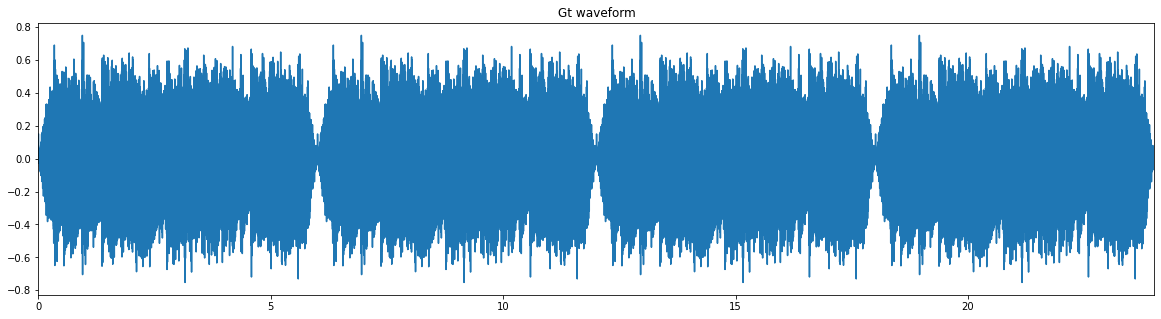

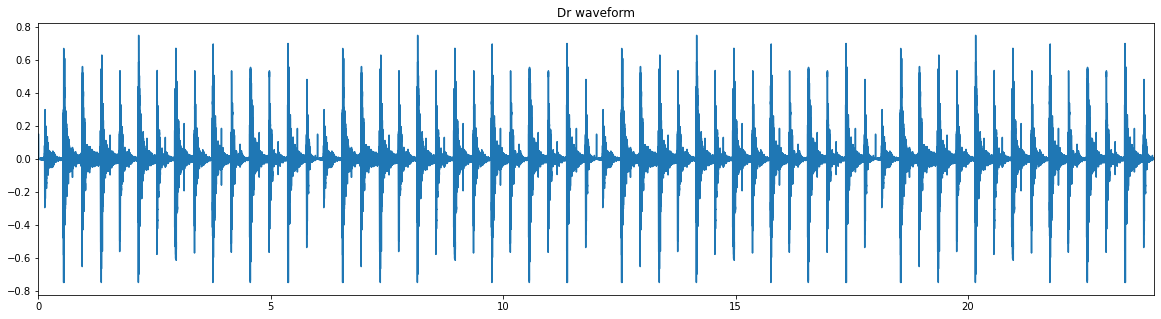

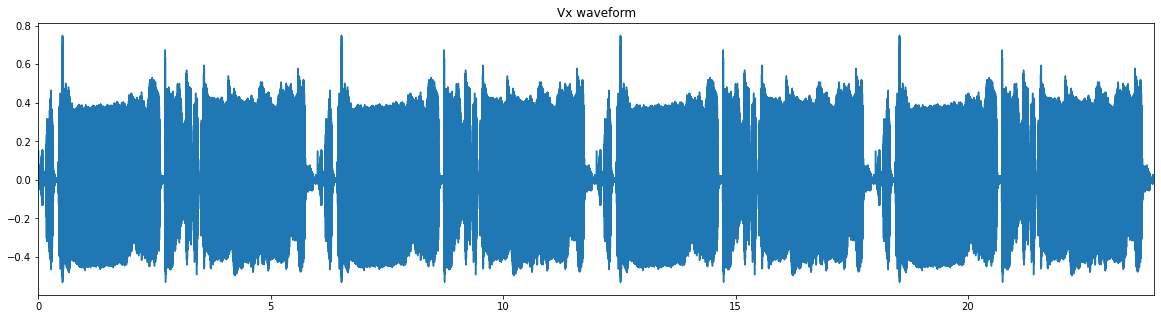

In [23]:
gains = metadata[sbj][stimulus_name]['wav_info']['gains']
pannings = metadata[sbj][stimulus_name]['wav_info']['panning']

plt.figure(figsize=(20,10))
for i, instrument in enumerate(instruments_list):
    sig = soli[i, :]
    gain = gains[i]
    panning = pannings[i]  
    
    print('Instrument: ' + instrument)
    print('- gain: ' + str(gain))
    print('- panning: ' + str(panning))
    
    T = len(sig)/sfreq

    plt.figure(figsize=(20,5))
    plt.plot(np.linspace(0, T, len(sig)), sig)
    plt.xlim((0,T))
    plt.title(instrument + ' waveform')

The 20-channel EEG data are stored in the field 'response' in a numpy array of shape (channels x samples). 

In [24]:
response = data[sbj][stimulus_name]['response']
print(type(response))
print(response.shape)

<class 'h5py._hl.dataset.Dataset'>
(20, 6148)


and the corresponding metadata can be found in the 'eeg_info' field

In [27]:
eeg_info = metadata[sbj][stimulus_name]['eeg_info']
eeg_info

{'ch_names': ['F3',
  'F1',
  'Fz',
  'F2',
  'F4',
  'C3',
  'C1',
  'Cz',
  'C2',
  'C4',
  'CPz',
  'P3',
  'P1',
  'Pz',
  'P2',
  'P4',
  'POz',
  'O1',
  'Oz',
  'O2'],
 'nchan': 20,
 'sfreq': 256.0}

If one needs to use the mne utils, e.g., for plotting, it is easy to create a raw object

Creating RawArray with float64 data, n_channels=20, n_times=6148
    Range : 0 ... 6147 =      0.000 ...    24.012 secs
Ready.


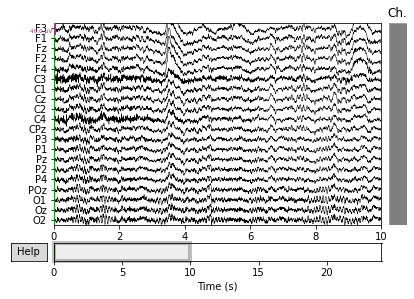

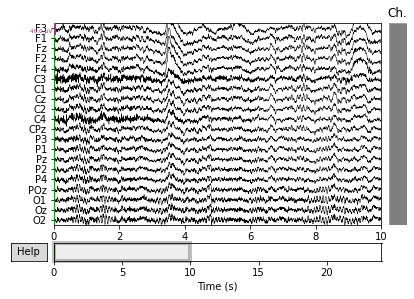

In [28]:
import mne

eeg_info = metadata[sbj][stimulus_name]['eeg_info']
ch_names = eeg_info['ch_names']
nchan = eeg_info['nchan']
eeg_sfreq = eeg_info['sfreq']
info = mne.create_info(ch_names=ch_names, ch_types=['eeg']*nchan, sfreq=eeg_sfreq)
raw = mne.io.RawArray(response, info)
raw.plot()

## Raw data
In the 'raw' subfolder, one can find the raw EEG responses and all the music stimuli. In the same folder, one can find all the information to synchronize those with the corresponding audio stimuli.

In [32]:
path = './raw'
os.listdir(path)

['madeeg_sequences_raw.yaml', 'madeeg_raw.yaml', 'madeeg_raw.hdf5', 'stimuli']

The .hdf5 file contains the EEG data grouped by subject

In [33]:
data = h5py.File(os.path.join(path, 'madeeg_raw.hdf5'), 'r')
data.keys()

<KeysViewHDF5 ['0001', '0002', '0003', '0004', '0005', '0007', '0008', '0009']>

The madeeg_raw.yaml file contains the EEG metadata

In [34]:
stream = open(os.path.join(path, 'madeeg_raw.yaml'), 'r')
metadata = yaml.load(stream, Loader=yaml.FullLoader)
metadata.keys()

dict_keys(['0001', '0002', '0003', '0004', '0005', '0007', '0008', '0009'])

Inside each group, one can find the EEG data of the given subject and the corresponding metadata.

In [35]:
sbj = '0001'
eeg_data = data[sbj]
eeg_info = metadata[sbj]

print(type(eeg_data[()]))
print(eeg_data.shape)
print(eeg_info.keys())

<class 'numpy.ndarray'>
(30, 1520896)
dict_keys(['acq_pars', 'acq_stim', 'bads', 'buffer_size_sec', 'ch_names', 'ch_types', 'chs', 'comps', 'concat_begin', 'ctf_head_t', 'custom_ref_applied', 'description', 'dev_ctf_t', 'dig', 'events', 'experimenter', 'file_id', 'filename', 'highpass', 'hpi_meas', 'hpi_results', 'hpi_subsystem', 'kit_system_id', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'nchan', 'proj_id', 'proj_name', 'projs', 'sfreq', 'subject_info', 'xplotter_layout'])


As before, it is easy to create a raw object

In [ ]:
import mne

ch_names = eeg_info['ch_names']
ch_types = eeg_info['ch_types']
eeg_sfreq = eeg_info['sfreq']
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=eeg_sfreq)
raw = mne.io.RawArray(eeg_data, info)

In [ ]:
The info needed for the synchronization with the audio stimuli are in the madeeg_sequences_raw.yaml and are also grouped by subject.